# QA and Chat over Documents

Chat and Question-Answeing (QA) over `data` is a popular LLM use-case.

`data` can include:

* `Unstructured data` (e.g., PDFs)
* `Structured data` (e.g., SQL)
* `Code` (e.g., Python)

LangChain supports Chat and QA various `data` types:

* See [here](https://python.langchain.com/docs/use_cases/code/) and [here](https://twitter.com/cristobal_dev/status/1675745314592915456?s=20) for `Code` 
* See [here](https://python.langchain.com/docs/use_cases/tabular) for `Structured data`

Below we will review Chat and QA on `Unstructured data`. 

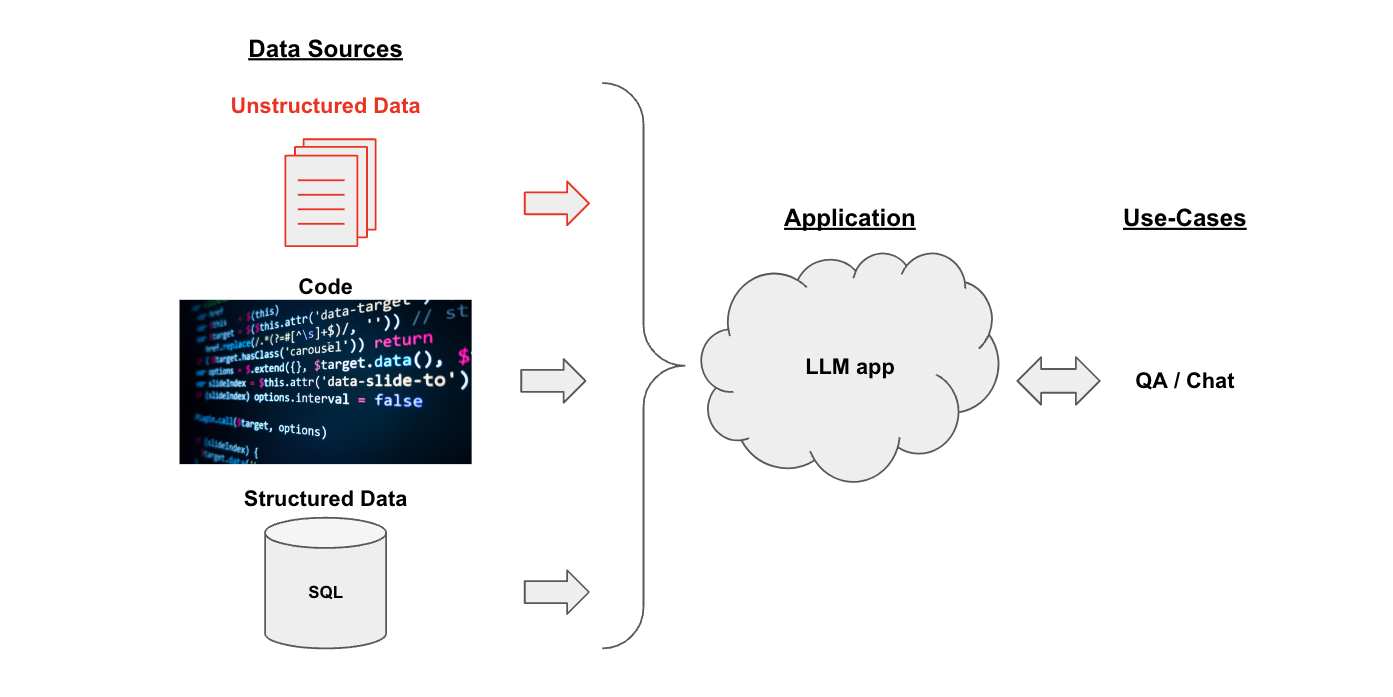

`Unstructured data` can be loaded from many sources.

Use the [LangChain integration hub](https://integrations.langchain.com/) to browse the full set of loaders.

Each loader returns data as a LangChain [`Document`](https://docs.langchain.com/docs/components/schema/document).

`Documents` are turned into a Chat or QA app following the steps below:

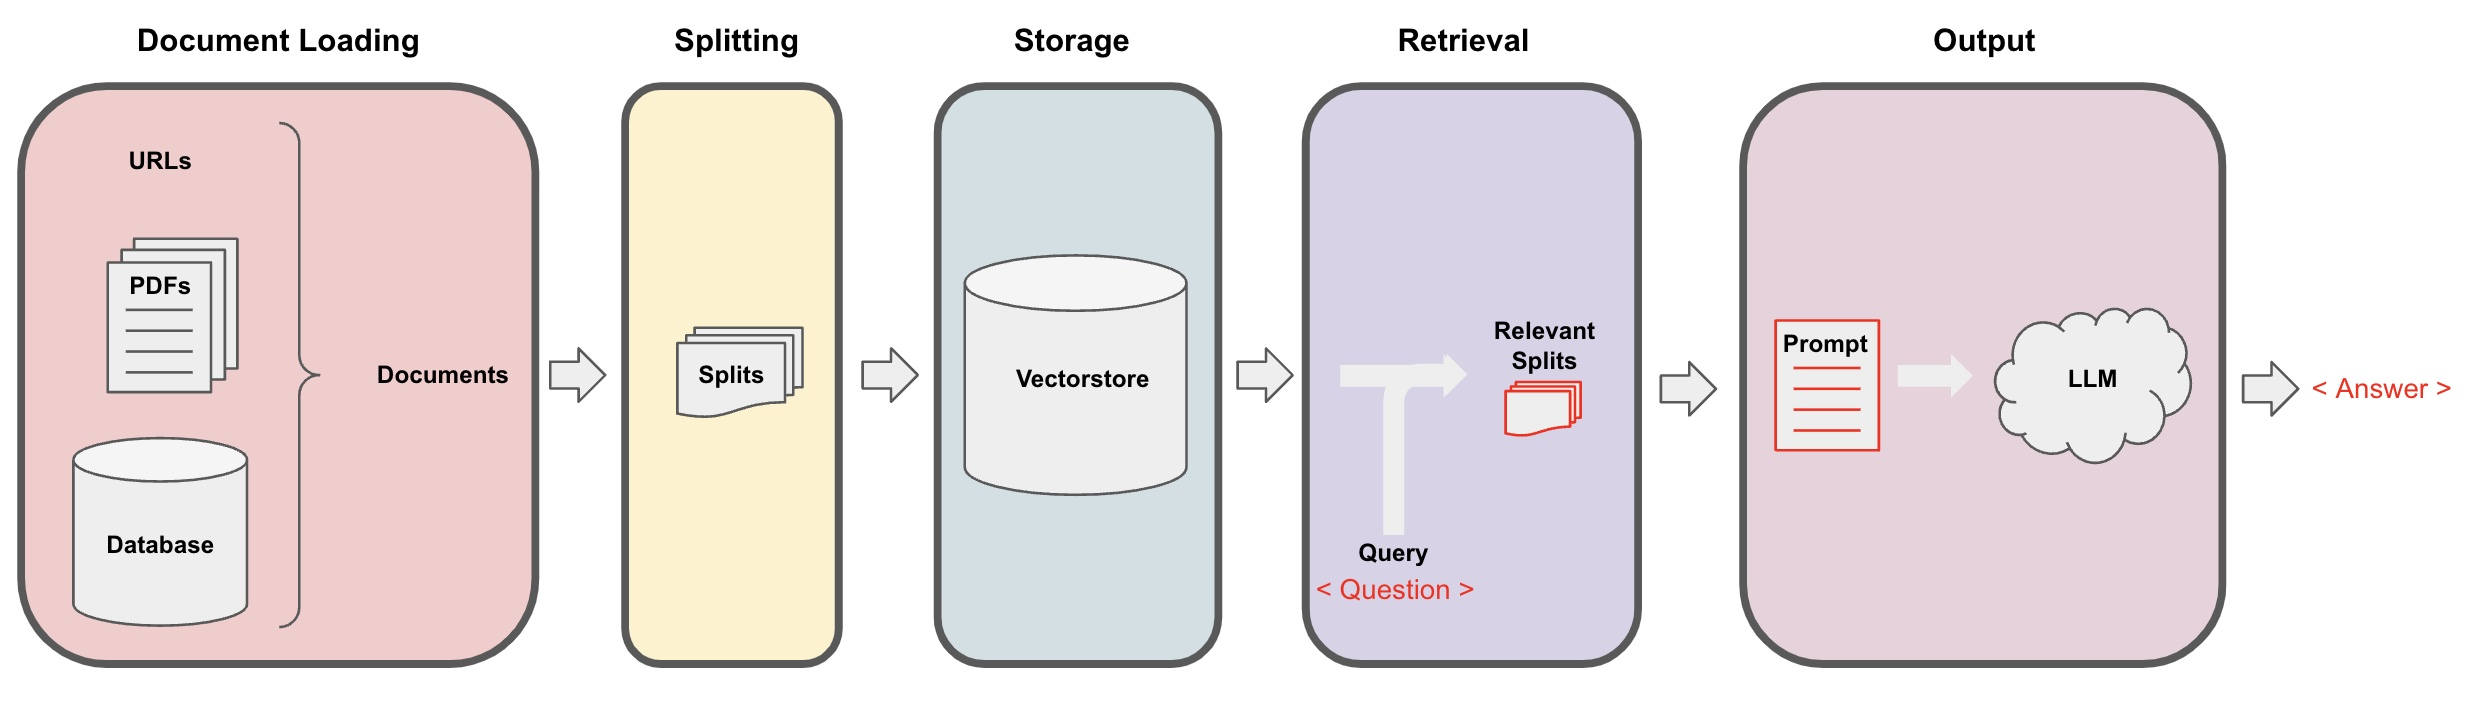

---

## Quickstart 

The above pipeline can be wrapped with a `VectorstoreIndexCreator`.

Let's load this [blog post](https://lilianweng.github.io/posts/2023-06-23-agent/) as an example `Document`.

We have a QA app in a few lines of code.

In [2]:
from langchain.document_loaders import WebBaseLoader
from langchain.indexes import VectorstoreIndexCreator
# Document loader
loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
# Index that wraps above steps
index = VectorstoreIndexCreator().from_loaders([loader])
# Question-answering
question = "What is Task Decomposition?"
index.query(question)

' Task decomposition is a technique used to break down complex tasks into smaller and simpler steps. It can be done using LLM with simple prompting, task-specific instructions, or with human input.'

---

## 1. Loading, Splitting, Storage

Of course, we may want to configure each stage.

### 1.1 Getting started

Specify a `Document` loader.

In [3]:
# Document loader
from langchain.document_loaders import WebBaseLoader
loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
data = loader.load()

Split the `Document` into chunks for embedding and vector storage.

In [4]:
# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 500, chunk_overlap = 0)
all_splits = text_splitter.split_documents(data)

Embed and store the splits in a vector database ([Chroma](https://python.langchain.com/docs/modules/data_connection/vectorstores/integrations/chroma)).

In [5]:
# Store 
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
vectorstore = Chroma.from_documents(documents=all_splits,embedding=OpenAIEmbeddings())

Here are the three pieces together:

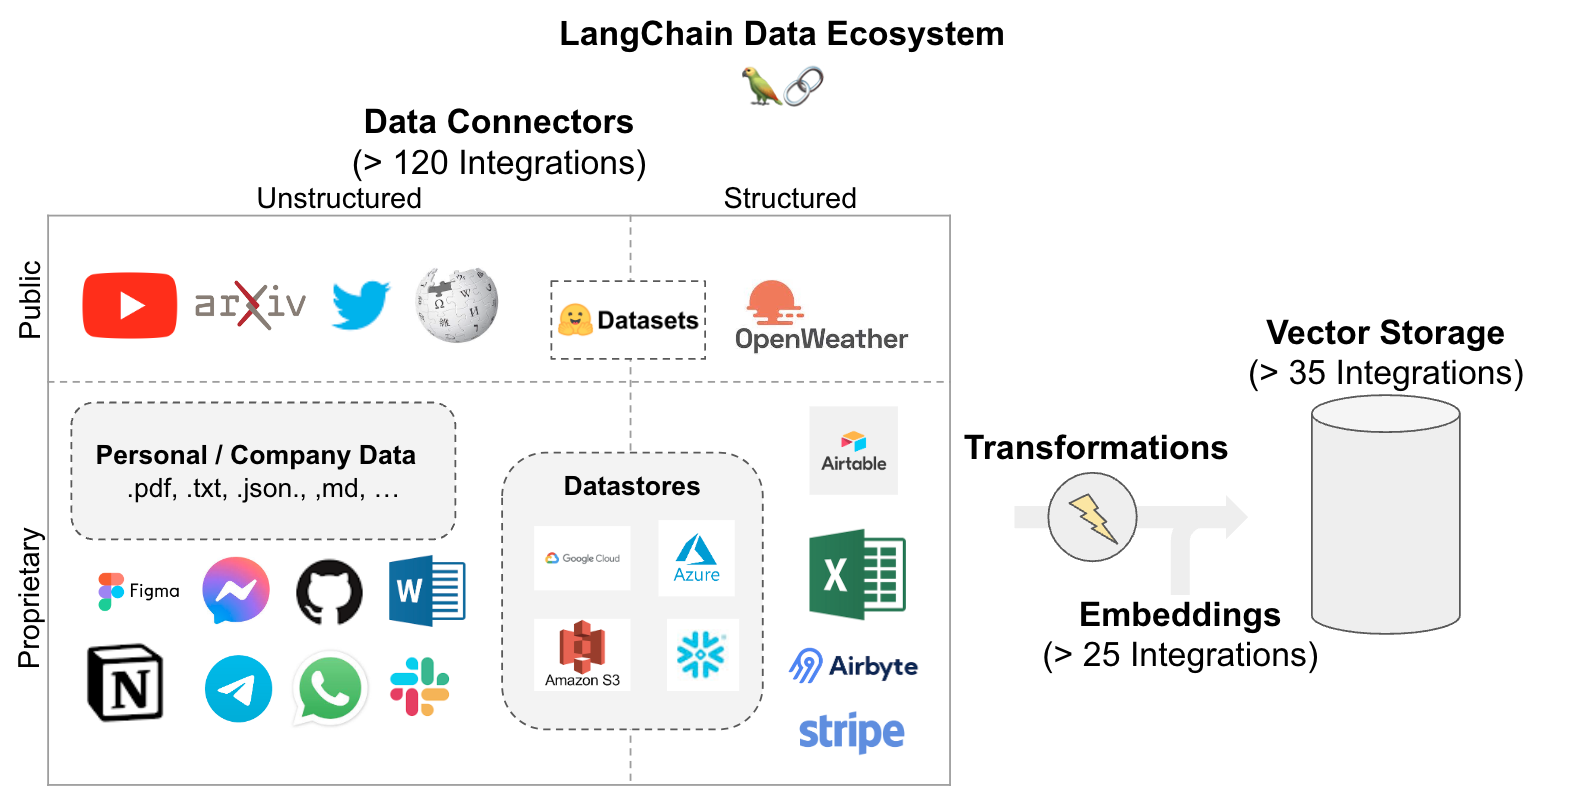

### 1.2 Going Deeper

#### 1.2.1 Integrations

`Data Loaders`
 
* Browse the > 120 data loader integrations [here](https://integrations.langchain.com/).

* See further documentation on loaders [here](https://python.langchain.com/docs/modules/data_connection/document_loaders/).

`Data Transformers`

* All can ingest loaded `Documents` and process them (e.g., split).

* See further documentation on transformers [here](https://python.langchain.com/docs/modules/data_connection/document_transformers/).

`Vectorstores`
 
* Browse the > 35 vectorstores integrations [here](https://integrations.langchain.com/).
 
* See further documentation on vectorstores [here](https://python.langchain.com/docs/modules/data_connection/vectorstores/). 
 
#### 1.2.2 Retaining metadata

`Context-aware splitters` keep the location or "context" of each split in the origional `Document`:

* [Markdown files](https://python.langchain.com/docs/use_cases/question_answering/document-context-aware-QA)
* [Code (py or js)](https://python.langchain.com/docs/modules/data_connection/document_loaders/integrations/source_code)
* [Documents](https://python.langchain.com/docs/modules/data_connection/document_loaders/integrations/grobid)

---

## 2. Retrieval 

### 2.1 Getting started
  
Retrieve [relevant splits](https://www.pinecone.io/learn/what-is-similarity-search/) for any question using `similarity_search`.

In [6]:
question = "What are the approaches to Task Decomposition?"
docs = vectorstore.similarity_search(question)
len(docs)

4

### 2.2 Going Deeper

#### 2.2.1 Advanced retrieval

Improve on `similarity_search`:

* `MultiQueryRetriever` [generates variants of the input question](https://python.langchain.com/docs/modules/data_connection/retrievers/how_to/MultiQueryRetriever) to improve retrieval.

* `Max marginal relevance` selects for [relevance and diversity](https://www.cs.cmu.edu/~jgc/publication/The_Use_MMR_Diversity_Based_LTMIR_1998.pdf) among the retrieved documents.

* Documents can be filtered during retrieval using [`metadata` filters](https://python.langchain.com/docs/use_cases/question_answering/document-context-aware-QA).

In [7]:
# MultiQueryRetriever
import logging
from langchain.chat_models import ChatOpenAI
from langchain.retrievers.multi_query import MultiQueryRetriever
logging.basicConfig()
logging.getLogger('langchain.retrievers.multi_query').setLevel(logging.INFO)
retriever_from_llm = MultiQueryRetriever.from_llm(retriever=vectorstore.as_retriever(),
                                                  llm=ChatOpenAI(temperature=0))
unique_docs = retriever_from_llm.get_relevant_documents(query=question)
len(unique_docs)

INFO:langchain.retrievers.multi_query:Generated queries: ['1. How can Task Decomposition be approached?', '2. What are the different methods for Task Decomposition?', '3. What are the various approaches to decomposing tasks?']


5

---

## 3. QA

### 3.1 Getting started

Distill the retried documents into an answer using an LLM (e.g., `gpt-3.5-turbo`) with `RetrievalQA` chain.

In [8]:
from langchain.chat_models import ChatOpenAI
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)
from langchain.chains import RetrievalQA
qa_chain = RetrievalQA.from_chain_type(llm,retriever=vectorstore.as_retriever())
qa_chain({"query": question})

{'query': 'What are the approaches to Task Decomposition?',
 'result': 'The approaches to task decomposition include:\n\n1. Simple prompting: This approach involves using simple prompts or questions to guide the agent in breaking down a task into smaller subgoals. For example, the agent can be prompted with "Steps for XYZ" and asked to list the subgoals for achieving XYZ.\n\n2. Task-specific instructions: In this approach, task-specific instructions are provided to the agent to guide the decomposition process. For example, if the task is to write a novel, the agent can be instructed to "Write a story outline" as a subgoal.\n\n3. Human inputs: This approach involves incorporating human inputs in the task decomposition process. Humans can provide guidance, feedback, and suggestions to help the agent break down complex tasks into manageable subgoals.\n\nThese approaches aim to enable efficient handling of complex tasks by breaking them down into smaller, more manageable subgoals.'}

### 3.2 Going Deeper

#### 3.2.1 Integrations

`LLMs`
 
* Browse the > 55 model integrations [here](https://integrations.langchain.com/).
 
* See further documentation on vectorstores [here](https://python.langchain.com/docs/modules/model_io/models/). 

#### 3.2.2 Running LLMs locally

The popularity of [PrivateGPT](https://github.com/imartinez/privateGPT) and [GPT4All](https://github.com/nomic-ai/gpt4all) underscore the importance of running LLMs locally.

LangChain has integrations with many open source LLMs that can be run locally.
 
Using `GPT4All` is as simple as [downloading the binary]((https://python.langchain.com/docs/modules/model_io/models/llms/integrations/gpt4all)) and then:

In [ ]:
from langchain.llms import GPT4All
from langchain.chains import RetrievalQA
llm = GPT4All(model="/Users/rlm/Desktop/Code/gpt4all/models/nous-hermes-13b.ggmlv3.q4_0.bin",max_tokens=2048)
qa_chain = RetrievalQA.from_chain_type(llm,retriever=vectorstore.as_retriever())

In [11]:
qa_chain({"query": question})

{'query': 'What are the approaches to Task Decomposition?',
 'result': ' There are three main approaches to task decomposition: (1) using language models like GPT-3 for simple prompting such as "Steps for XYZ.\\n1.", (2) using task-specific instructions, and (3) with human inputs.'}

#### 3.2.2 Customizing the prompt

The prompt in `RetrievalQA` chain can be easily customized.

In [18]:
# Build prompt
from langchain.prompts import PromptTemplate
template = """Use the following pieces of context to answer the question at the end. 
If you don't know the answer, just say that you don't know, don't try to make up an answer. 
Use three sentences maximum and keep the answer as concise as possible. 
Always say "thanks for asking!" at the end of the answer. 
{context}
Question: {question}
Helpful Answer:"""
QA_CHAIN_PROMPT = PromptTemplate(input_variables=["context", "question"],template=template,)

# Run chain
from langchain.chains import RetrievalQA
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)
qa_chain = RetrievalQA.from_chain_type(llm,
                                       retriever=vectorstore.as_retriever(),
                                       chain_type_kwargs={"prompt": QA_CHAIN_PROMPT})

result = qa_chain({"query": question})
result["result"]

'The approaches to Task Decomposition are (1) using simple prompting by LLM, (2) using task-specific instructions, and (3) with human inputs. Thanks for asking!'

#### 3.2.3 Returning source documents

The full set of retrieved documents used for answer distillation can be returned using `return_source_documents=True`.

In [14]:
from langchain.chains import RetrievalQA
qa_chain = RetrievalQA.from_chain_type(llm,retriever=vectorstore.as_retriever(),
                                       return_source_documents=True)
result = qa_chain({"query": question})
print(len(result['source_documents']))
result['source_documents'][0]

4


Document(page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:', 'language': 'en'})

#### 3.2.4 Citations

Answer citations can be returned using `RetrievalQAWithSourcesChain`.

In [15]:
from langchain.chains import RetrievalQAWithSourcesChain
qa_chain = RetrievalQAWithSourcesChain.from_chain_type(llm,retriever=vectorstore.as_retriever())
result = qa_chain({"question": question})
result

{'question': 'What are the approaches to Task Decomposition?',
 'answer': 'The approaches to Task Decomposition include (1) using LLM with simple prompting, (2) using task-specific instructions, and (3) incorporating human inputs.\n',
 'sources': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}

#### 3.2.5 Customizing how we process the retrieved documents

Retrieved documents can be fed to an LLM for answer distillation in a few different ways.

`stuff`, `refine`, `map-reduce`, and `map-rerank` chains for passing documents to an LLM prompt an well summarized [here](https://python.langchain.com/docs/modules/chains/document/).
 
In short, `stuff` is the most commonly used because it "stuffs" all retrieved documents into the prompt.

The [load_qa_chain](https://python.langchain.com/docs/modules/chains/additional/question_answering.html) is an easy way to pass documents to an LLM (`return_only_outputs=True` returns only the answer).

In [17]:
from langchain.chains.question_answering import load_qa_chain
chain = load_qa_chain(llm, chain_type="stuff")
chain({"input_documents": unique_docs, "question": question},return_only_outputs=True)

{'output_text': 'The approaches to task decomposition include (1) using simple prompting to break down tasks into subgoals, (2) providing task-specific instructions to guide the decomposition process, and (3) incorporating human inputs for task decomposition.'}

We can also pass the `chain_type` to `RetrievalQA`.

In [55]:
qa_chain = RetrievalQA.from_chain_type(llm,retriever=vectorstore.as_retriever(),
                                       chain_type="stuff")
result = qa_chain({"query": question})

The user can choose the desired level of abstraction for QA:

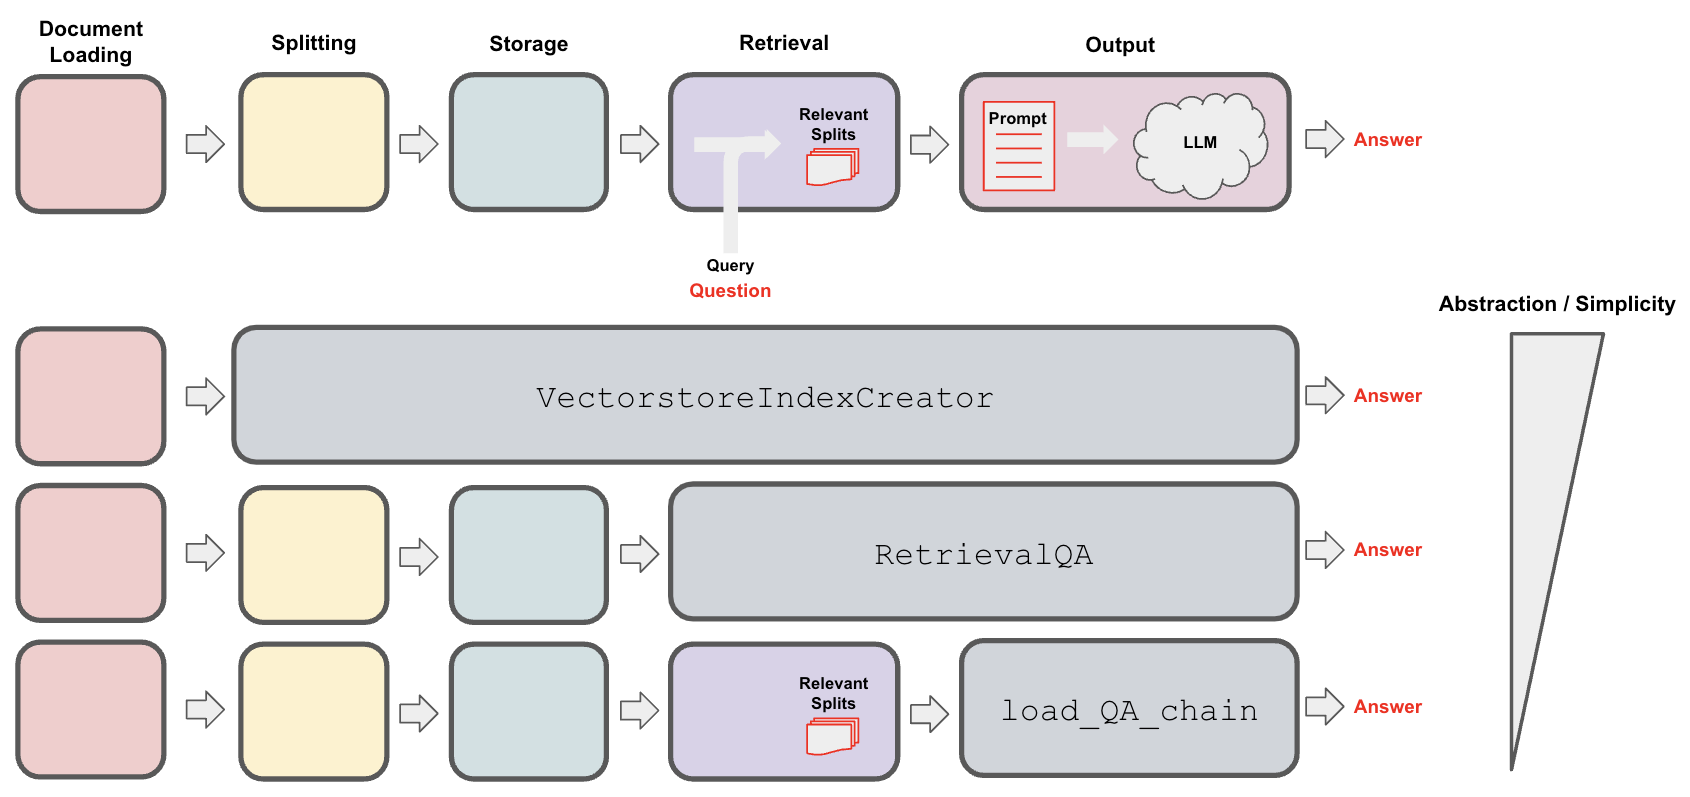

---

## 4. Chat

### 4.1 Getting started

To keep chat history, first specify a `Memory buffer` to track the conversation inputs / outputs.

In [19]:
from langchain.memory import ConversationBufferMemory
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

The `ConversationalRetrievalChain` uses chat in the `Memory buffer`. 

In [20]:
from langchain.chains import ConversationalRetrievalChain
retriever=vectorstore.as_retriever()
chat = ConversationalRetrievalChain.from_llm(llm,retriever=retriever,memory=memory)

In [21]:
result = chat({"question": "What are some of the main ideas in self-reflection?"})
result['answer']

"Some of the main ideas in self-reflection include:\n1. Iterative improvement: Self-reflection allows autonomous agents to improve by refining past action decisions and correcting mistakes.\n2. Trial and error: Self-reflection is crucial in real-world tasks where trial and error are inevitable.\n3. Two-shot examples: Self-reflection is created by showing pairs of failed trajectories and ideal reflections for guiding future changes in the plan.\n4. Working memory: Reflections are added to the agent's working memory, up to three, to be used as context for querying.\n5. Performance evaluation: Self-reflection involves continuously reviewing and analyzing actions, self-criticizing behavior, and reflecting on past decisions and strategies to refine approaches.\n6. Efficiency: Self-reflection encourages being smart and efficient, aiming to complete tasks in the least number of steps."

The `Memory buffer` has context to resolve `"it"` ("self-reflection") in the below question.

In [22]:
result = chat({"question": "How does the Reflexion paper handle it?"})
result['answer']

"The Reflexion paper handles self-reflection by showing two-shot examples to the Learning Language Model (LLM). Each example consists of a failed trajectory and an ideal reflection that guides future changes in the agent's plan. These reflections are then added to the agent's working memory, up to a maximum of three, to be used as context for querying the LLM. This allows the agent to iteratively improve its reasoning skills by refining past action decisions and correcting previous mistakes."

### 4.2 Going deeper

The [documentation](https://python.langchain.com/docs/modules/chains/popular/chat_vector_db) on `ConversationalRetrievalChain` offers a few extensions, such as streaming and source documents.